In [1]:
import pandas as pd
df = pd.read_excel('各品牌汽车销售数据.xlsx')
df.head()

,品牌,2024,2023,2022,2021,2020,合计
0,比亚迪,3489908,2391555,1583025,525711,144149,8505805
1,吉利汽车,1048619,911563,813357,1051807,1007151,5040946
2,长安,827428,960285,844763,868710,807091,4429216
3,奇瑞,545463,392940,287115,326232,247243,1894019
4,特斯拉,661276,610692,441697,322562,147445,2246719


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15312\448178347.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


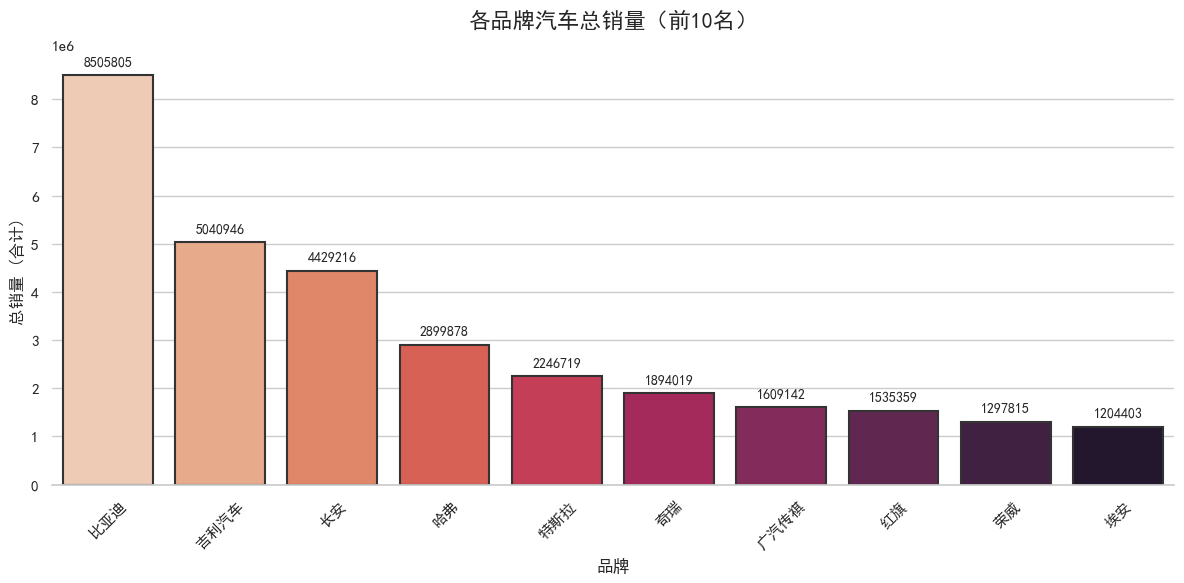

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置Seaborn主题和字体（解决中文显示问题）
sns.set_theme(style="whitegrid")  # 可选主题：darkgrid/whitegrid/dark/white/ticks
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 按合计列降序排序，选择前10个品牌
top_brands = df.sort_values(by='合计', ascending=False).head(10)

# 绘制柱状图
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='品牌', 
    y='合计', 
    data=top_brands,
    palette="rocket_r",  # 颜色方案：Blues/rocket/viridis等
    edgecolor=".2",     # 边框颜色
    linewidth=1.5       # 边框宽度
)

# 添加数据标签
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=10
    )

# 图表美化
plt.title('各品牌汽车总销量（前10名）', fontsize=16, pad=20)
plt.xlabel('品牌', fontsize=12)
plt.ylabel('总销量 (合计)', fontsize=12)
plt.xticks(rotation=45)
sns.despine(left=True)  # 移除左边框
plt.tight_layout()
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15312\1879752916.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


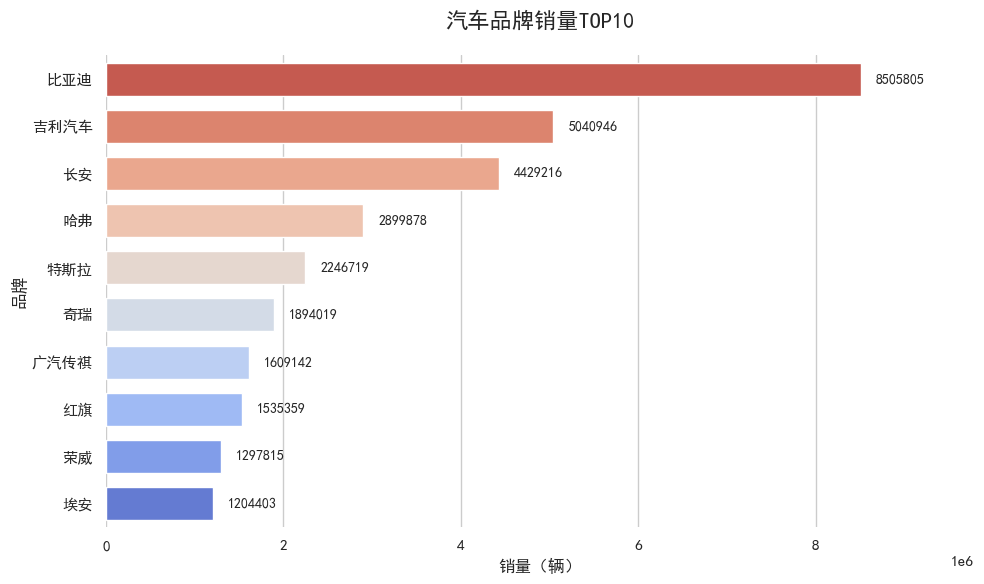

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 主题与样式设置（参考[6][8]）
sns.set_theme(
    style="whitegrid",
    rc={
        'font.sans-serif': ['SimHei'],
        'axes.unicode_minus': False,
        'axes.linewidth': 1.5
    }
)

# 2. 数据处理（按合计降序取前10）
top_brands = df.sort_values('合计', ascending=False).head(10)

# 3. 创建横向条形图（核心参数参考[2][3][5]）
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='合计',
    y='品牌',
    data=top_brands,
    palette="coolwarm_r",  # 横向图建议使用_r反转色板
    saturation=0.8,
    width=0.7,
    orient='h'            # 关键参数（参考[3]）
)

# 4. 添加数据标签（参考[7]实践）
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + max(top_brands['合计'])*0.02,  # 动态偏移量
        p.get_y() + p.get_height()/2,
        f"{int(width)}",
        va='center',
        fontsize=10
    )

# 5. 图表美化（综合[1][6]）
plt.title('汽车品牌销量TOP10', fontsize=16, pad=20)
plt.xlabel('销量（辆）', fontsize=12)
plt.ylabel('品牌', fontsize=12)
plt.xlim(0, max(top_brands['合计'])*1.15)  # 扩展X轴范围
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

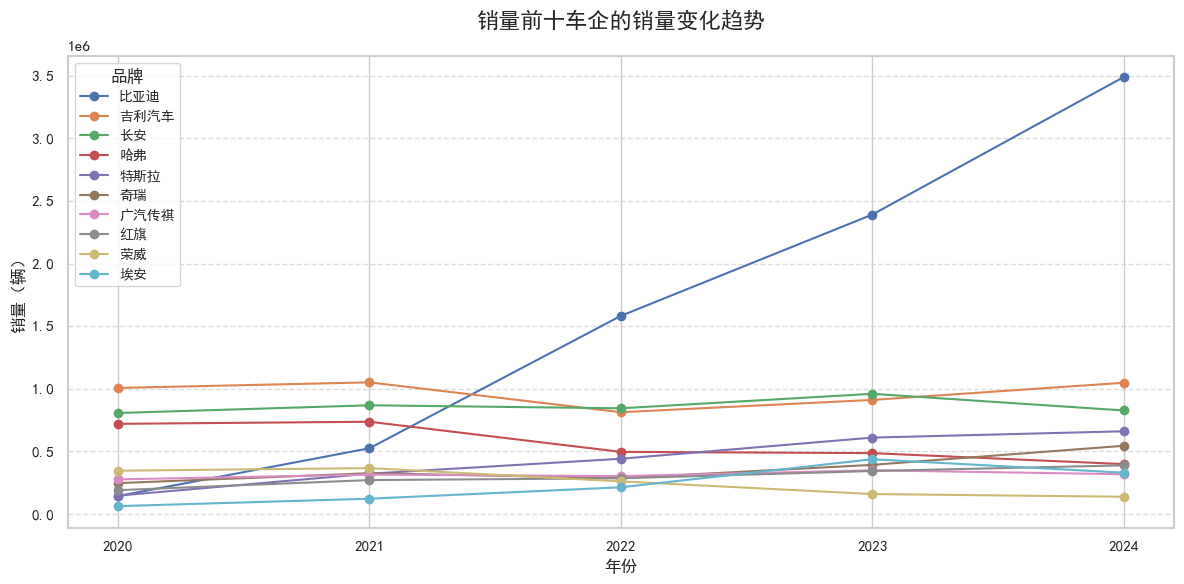

In [4]:
# 提取销量前十车企的年份数据
years = ['2020', '2021', '2022', '2023', '2024']
top_brands.columns = top_brands.columns.astype(str)  # 将列名转换为字符串
top_brands_time_series = top_brands[['品牌'] + years].set_index('品牌').T

# 绘制折线图
plt.figure(figsize=(12, 6))
for brand in top_brands_time_series.columns:
    plt.plot(top_brands_time_series.index, top_brands_time_series[brand], marker='o', label=brand)

# 图表美化
plt.title('销量前十车企的销量变化趋势', fontsize=16, pad=20)
plt.xlabel('年份', fontsize=12)
plt.ylabel('销量（辆）', fontsize=12)
plt.legend(title='品牌', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 提取比亚迪的销量数据
byd_sales = top_brands_time_series['比亚迪'].values.reshape(-1, 1)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
byd_sales_scaled = scaler.fit_transform(byd_sales)

# 创建训练数据
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 3  # 使用过去3年的数据预测下一年
X, y = create_dataset(byd_sales_scaled, time_step)

# 调整数据形状以适配 LSTM 输入
X = X.reshape(X.shape[0], X.shape[1], 1)

# 构建 LSTM 模型
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X, y, epochs=100, batch_size=1, verbose=1)

# 预测未来销量
last_sequence = byd_sales_scaled[-time_step:].reshape(1, time_step, 1)
predicted_scaled = model.predict(last_sequence)
predicted_sales = scaler.inverse_transform(predicted_scaled)

print(f"预测的比亚迪下一年的销量: {int(predicted_sales[0, 0])}")

Epoch 1/100
2/2 [==============================] - 5s 17ms/step - loss: 0.7323
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6963
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6701
Epoch 4/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6381
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6047
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.5641
Epoch 7/100
2/2 [==============================] - 0s 9ms/step - loss: 0.5324
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.4920
Epoch 9/100
2/2 [==============================] - 0s 14ms/step - loss: 0.4420
Epoch 10/100
2/2 [==============================] - 0s 10ms/step - loss: 0.3959
Epoch 11/100
2/2 [==============================] - 0s 16ms/step - loss: 0.3547
Epoch 12/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2938
Epoch 13/100
2/2 [==============================] - 0s 6

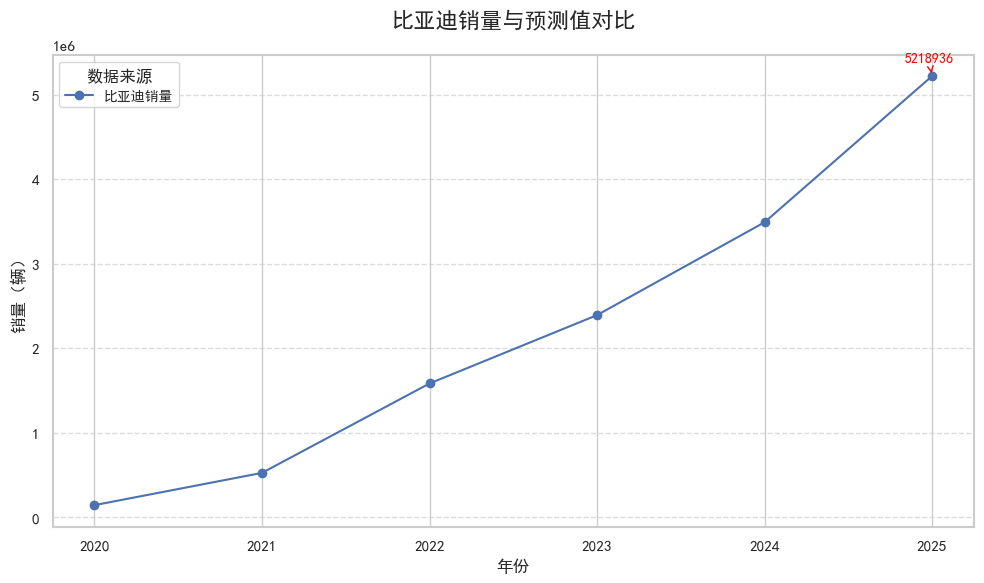

In [6]:
# 将预测值添加到已有数据中
years_with_prediction = years + ['2025']  # 添加预测年份
byd_sales_with_prediction = np.append(byd_sales.flatten(), int(predicted_sales[0, 0]))

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(years_with_prediction, byd_sales_with_prediction, marker='o', label='比亚迪销量', color='b')

# 标注预测值
plt.annotate(
    f"{int(predicted_sales[0, 0])}",
    xy=('2025', predicted_sales[0, 0]),
    xytext=(-20, 10),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='red'),
    fontsize=10,
    color='red'
)

# 图表美化
plt.title('比亚迪销量与预测值对比', fontsize=16, pad=20)
plt.xlabel('年份', fontsize=12)
plt.ylabel('销量（辆）', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='数据来源', fontsize=10)
plt.tight_layout()
plt.show()